In [1]:
!pip install pyspark
!pip install nltk -U
# Standard library
import os
import shutil
import io
import re
import warnings

# Third-party
import pandas as pd
import numpy as np
from scipy.special import comb
import seaborn as sns
import matplotlib.pyplot as plt

# Spark and GCP
import pyspark
from pyspark.sql import functions as f
from pyspark.sql.types import *
from pyspark.ml.feature import MinHashLSH, HashingTF, Normalizer
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.conf import SparkConf
from google.cloud import storage

# NLTK
import nltk

In [2]:
pd.set_option('display.max_colwidth', None)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
bucket = 'msca-bdp-students-bucket'
path = 'gs://msca-bdp-students-bucket/shared_data/pranavr569/tweets_classified'

### Helpers

In [3]:
def get_dups(model, hashed_df, record, jaccard_dist):
    
    dups = np.empty(shape=(3,))
    uniques = np.empty(shape=(3,))
    for index, val in np.ndenumerate(np.array(jaccard_dist)):
        dup_text = model.approxSimilarityJoin(hashed_df, hashed_df, val).filter("datasetA.id < datasetB.id").select(
                                                        f.col("distCol"),
                                                        f.col("datasetA.id").alias("id_A"))
        dups_val = dup_text.select('id_A').count()
        uniques_val = record - dups_val
        
        dups[index] = dups_val
        uniques[index] = uniques_val
        
    
    df = pd.DataFrame.from_dict({'Near Duplicates': ((dups / record) * 100).round(2), 
                                 'Unique': ((uniques / record) * 100).round(2), 
                                 'Jaccard': pd.Categorical(['0.3', '0.5', '0.7'], categories = ['0.3', '0.5', '0.7'])})
    return df.melt(id_vars='Jaccard', value_vars=['Near Duplicates', 'Unique'], value_name = 'Percentages', var_name='Type')

In [4]:
@f.udf(returnType=DoubleType())
def dot_prod(v1, v2):
    return float(v1.dot(v2))

In [5]:
def plot(data):
    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 12})
    fig = sns.barplot(x='Jaccard', y='Percentages', hue='Type', data=data, ci=None)
    fig.set_xlabel('Jaccard')
    fig.set_ylabel('Percentages')

    for container in fig.containers:
        fig.bar_label(container, labels=[f'{x}%' for x in container.datavalues] ,label_type='edge')
    handles, labels = fig.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))    
    return fig

### Read Data

In [6]:
df = spark.read.parquet(path).select(['tweet_id', 'tweet_text', 'Category'])

23/03/11 00:09:21 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
df.count()

12876408

In [7]:
# Keep only unique tweet_id
df = df.dropDuplicates(['tweet_id'])


In [8]:
# Remove null user_type and 'other'
df = df.filter(f.col('Category').isNotNull())


In [10]:
# Check unique groups
user_types = df.select('Category').distinct().toPandas()
user_types

,Category
0,Nonprofit_organization
1,Government
2,Influencer
3,Other
4,Celebrity
5,Educational_institute
6,News


In [11]:
df.limit(20)

tweet_id,tweet_text,Category
1511197588628054018,education upbring...,Other
1511197761672462347,baghdadi p h hold...,Other
1511197853179387907,iprabhatmishraa p...,Other
1511198211939225605,make 40k year col...,Other
1511198483549618179,education upbring...,Other
1511198993627467778,living butler col...,Other
1511199077656150019,marychaostyle far...,Other
1511199473237565446,anyone please who...,Other
1511200276069650434,enchanted sunsun ...,Other
1511200389554704389,tittiesonice keyo...,Other


## How unique are the messages?

## 1) Government

In [9]:
govn_perc = 0.32

In [10]:
df_govn = df.filter(f.col('Category') == 'Government').sample(govn_perc, seed=1227)
df_govn.count()

9299

In [11]:
# Rename since minhash depends on the name 'text'
govn_raw = df_govn.select(['tweet_text']).withColumnRenamed('tweet_text', 'text')

In [12]:
govn_extracted = govn_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

tokens_govn = (govn_extracted
        .map(lambda document: document.strip().lower()) # Remove leading and trailing characters, then convert to lower case
        .map(lambda document: re.split(" ", document)) # Split each sentence on white spaces so each word is a token
        .map(lambda word: [x for x in word if x.isalnum()]) # All characters must be alphanumeric
        .zipWithIndex())

In [13]:
row = Row('text')
df_text=govn_extracted.map(row).zipWithIndex().toDF(['text','id'])

In [14]:
df_govn_tokens = spark.createDataFrame(tokens_govn, ["list_of_words",'id'])

### Countvectorizer

In [15]:
vectorize_govn = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_govn = vectorize_govn.fit(df_govn_tokens).transform(df_govn_tokens)

In [16]:
df_vectorize_govn.filter(f.size(f.col('list_of_words')) < 1).count()

0

In [17]:
df_vectorize_govn = df_vectorize_govn.filter((f.size(f.col('list_of_words')) >= 1))

In [18]:
df_vectorize_govn.filter(f.size(f.col('list_of_words')) < 1).count()

0

### Minhash

In [19]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model_govn = mh.fit(df_vectorize_govn)
df_hashed = mh.fit(df_vectorize_govn).transform(df_vectorize_govn).cache()

In [20]:
df_hashed_govn = df_text.join(df_hashed, on='id', how = 'left').cache()

In [21]:
records_govn = df_hashed_govn.count()
records_govn

9358

### Plot

In [22]:
govn = get_dups(model_govn, df_hashed_govn, records_govn, [0.3, 0.5, 0.7])

In [23]:
govn 

,Jaccard,Type,Percentages
0,0.3,Near Duplicates,12.10
1,0.5,Near Duplicates,14.47
2,0.7,Near Duplicates,19.21
3,0.3,Unique,87.90
4,0.5,Unique,85.53
5,0.7,Unique,80.79


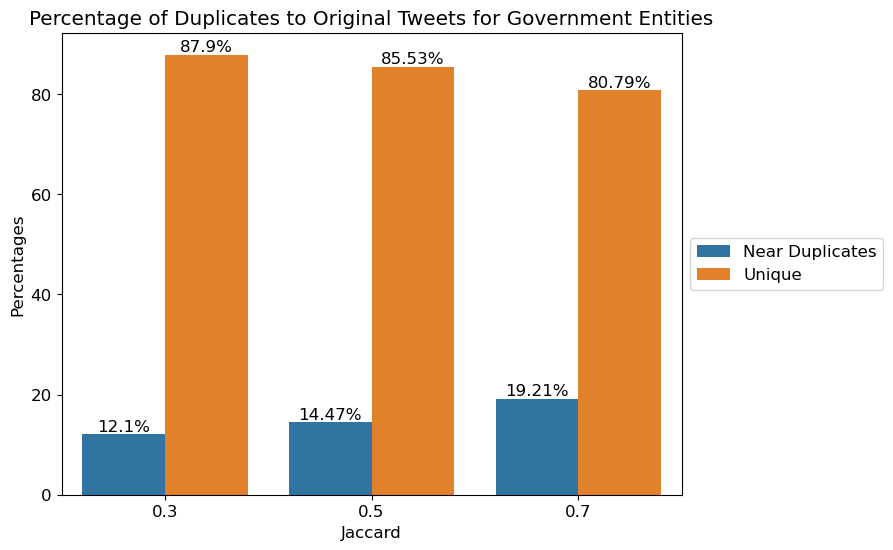

In [24]:
fig_govn = plot(govn)
plt.title("Percentage of Duplicates to Original Tweets for Government Entities")
plt.show()

In [29]:
df_hashed.unpersist()
df_hashed_govn.unpersist()

id,text,list_of_words,features,hashes
26,{mrjohnnicolson b...,"[mrjohnnicolson, ...","(29794,[3,4,6,25,...","[[1.6660839E7], [..."
29,{nominations powe...,"[nominations, pow...","(29794,[0,1,5,9,1...","[[5066495.0], [1...."
65,{appreciation twe...,"[appreciation, tw...","(29794,[0,3,22,96...","[[4.7945584E7], [..."
191,{ellieeve21 kjl7x...,"[ellieeve21, kjl7...","(29794,[2,24,26,1...","[[2.61390943E8], ..."
222,{princeton activi...,"[princeton, activ...","(29794,[2,17,121,...","[[1.41807682E8], ..."
270,{among 30 states ...,"[among, 30, state...","(29794,[1,6,8,24,...","[[1.19094037E8], ..."
293,{lost student cou...,"[lost, student, c...","(29794,[6,7,10,21...","[[8.5791175E7], [..."
243,{conducted career...,"[conducted, caree...","(29794,[0,1,4,5,8...","[[1.6660839E7], [..."
278,{david mirikitani...,"[david, mirikitan...","(29794,[3,54,77,2...","[[1.8678956E7], [..."
19,{problems childre...,"[problems, childr...","(29794,[0,6,17,20...","[[1.8678956E7], [..."


## 2) Education

In [30]:
academics_perc = 0.07

In [31]:
df_academics = df.filter(f.col('Category') == 'Educational_institute').sample(academics_perc, 1227)
df_academics.count()

2016

### Raw

In [32]:
academics_raw = df_academics.select(['tweet_text']).withColumnRenamed('tweet_text', 'text')

In [33]:
academics_extracted = academics_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

tokens_academics = (academics_extracted
        .map(lambda document: document.strip().lower()) # Remove leading and trailing characters, then convert to lower case
        .map(lambda document: re.split(" ", document)) # Split each sentence on white spaces so each word is a token
        .map(lambda word: [x for x in word if x.isalnum()]) # All characters must be alphanumeric
        .zipWithIndex())

In [34]:
row = Row('text')
df_text=academics_extracted.map(row).zipWithIndex().toDF(['text','id'])

In [35]:
df_academics_tokens = spark.createDataFrame(tokens_academics, ["list_of_words",'id'])

### CounterVectorizer

In [36]:
vectorize_academics = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_academics = vectorize_academics.fit(df_academics_tokens).transform(df_academics_tokens)

In [37]:
df_vectorize_academics.limit(5).toPandas()

,list_of_words,id,features
0,"[substantial, investments, universityofga, research, facilities, new, poultry, science, complex, helping, generate, economic, activity, georgia, economy, learn, caes, impact]",0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[proposals, due, april, 17, research, grants, 5, 000, available, umich, graduate, students, anti, racism, research, projects, learn, amp, apply, co, sponsors, ncid, anti, racism, collaborative, umichgradschool, fordschool, center, racial, justice]",1,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[priority, deadline, columbus, promise, applications, friday, learn, program, provides, tuition, free, education, cscc, edu, watch, recap, recent, events, held, ccs, high, schools, district, seniors, ourccs, info]",2,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[kus, student, government, board, held, annual, safety, walk, wednesday, night, students, joined, university, officials, administrators, walked, campus, looked, aspects, campus, safety]",3,"(0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[thank, joining, us, meet, uscdps, chief, finalists, cal, poly, slo, police, chief, george, hughes, amp, la, school, police, chief, leslie, ramirez, learn, next, steps, amp, one, usc, safety, vision, voice, matters, usc]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...)"


In [38]:
df_vectorize_academics.filter(f.size(f.col('list_of_words')) < 1).count()

0

In [39]:
df_vectorize_academics = df_vectorize_academics.filter((f.size(f.col('list_of_words')) >= 1))

### Minhash

In [40]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model_academics = mh.fit(df_vectorize_academics)
df_hashed = mh.fit(df_vectorize_academics).transform(df_vectorize_academics).cache()

In [41]:
df_hashed_academics = df_text.join(df_hashed, on='id', how = 'left').cache()
df_hashed_academics.limit(10)

id,text,list_of_words,features,hashes
26,{student need buy...,"[student, need, b...","(11564,[0,5,48,80...","[[4.2397728E7], [..."
29,{proud partner ma...,"[proud, partner, ...","(11564,[0,7,16,89...","[[2.7257919E7], [..."
474,{ultimately combi...,"[ultimately, comb...","(11564,[1,78,101,...","[[3.1294153E7], [..."
964,{hoovercfisd pare...,"[hoovercfisd, par...","(11564,[0,6,9,16,...","[[4.7945584E7], [..."
1677,{fluid structure ...,"[fluid, structure...","(11564,[1,3,6,25,...","[[3.1294153E7], [..."
1697,{thank support ma...,"[thank, support, ...","(11564,[0,7,13,36...","[[4.7945584E7], [..."
1806,{principal school...,"[principal, schoo...","(11564,[0,9,24,51...","[[4.7945584E7], [..."
1950,{point republican...,"[point, republica...","(11564,[0,2,29,21...","[[4.7945584E7], [..."
2040,{bold new vision ...,"[bold, new, visio...","(11564,[1,7,10,11...","[[7.1672219E7], [..."
19,{meet autm member...,"[meet, autm, memb...","(11564,[1,10,77,9...","[[1.02442606E8], ..."


In [42]:
records_academics = df_hashed_academics.count()
records_academics

2125

### Plot

In [43]:
academics = get_dups(model_academics, df_hashed_academics, records_academics, [0.3, 0.5, 0.7])

In [44]:
academics 

,Jaccard,Type,Percentages
0,0.3,Near Duplicates,2.73
1,0.5,Near Duplicates,3.34
2,0.7,Near Duplicates,4.42
3,0.3,Unique,97.27
4,0.5,Unique,96.66
5,0.7,Unique,95.58


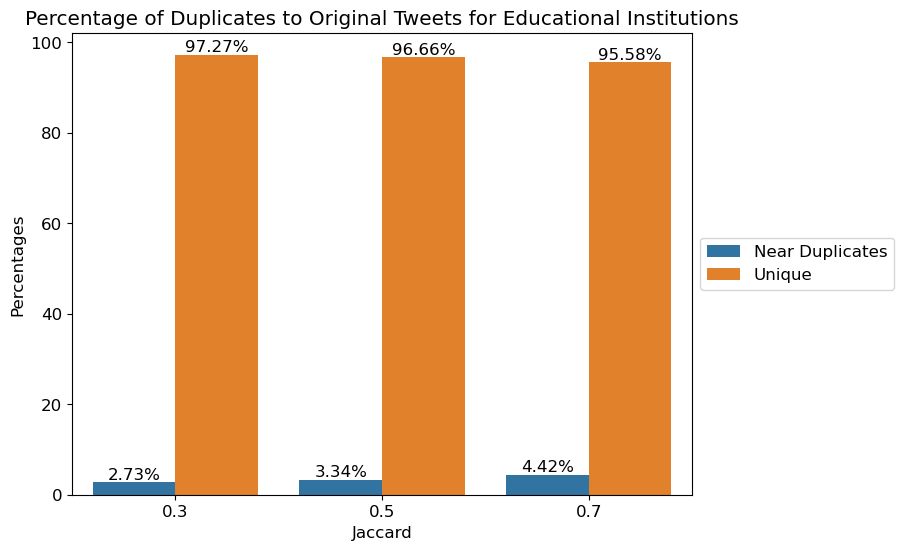

In [147]:
fig_academics = plot(academics)
plt.title("Percentage of Duplicates to Original Tweets for Educational Institutions")
plt.show()


In [48]:
df_hashed.unpersist()
df_hashed_academics.unpersist()

id,text,list_of_words,features,hashes
26,{student need buy...,"[student, need, b...","(11564,[0,5,48,80...","[[4.2397728E7], [..."
29,{proud partner ma...,"[proud, partner, ...","(11564,[0,7,16,89...","[[2.7257919E7], [..."
65,{dr kristofer sch...,"[dr, kristofer, s...","(11564,[0,2,6,25,...","[[4.7945584E7], [..."
19,{meet autm member...,"[meet, autm, memb...","(11564,[1,10,77,9...","[[1.02442606E8], ..."
54,{school choice se...,"[school, choice, ...","(11564,[0,6,7,9,1...","[[4.1891233E7], [..."
0,{substantial inve...,"[substantial, inv...","(11564,[7,10,11,4...","[[1.06494566E8], ..."
22,{early stem educa...,"[early, stem, edu...","(11564,[2,3,6,11,...","[[1.6660839E7], [..."
7,{hancock place hi...,"[hancock, place, ...","(11564,[0,12,16,6...","[[4.7945584E7], [..."
34,{watch michigan c...,"[watch, michigan,...","(11564,[0,3,4,12,...","[[1.2125973E7], [..."
50,{cincinnati man s...,"[cincinnati, man,...","(11564,[0,5,12,45...","[[1.8686819E7], [..."


## 3) Celebrity

In [51]:
celeb_perc = 0.55

In [52]:
df_celeb = df.filter(f.col('Category') == 'Celebrity').sample(celeb_perc, seed=1227)
df_celeb.count()

3984

### Raw

In [53]:
celeb_raw = df_celeb.select(['tweet_text']).withColumnRenamed('tweet_text', 'text')

In [54]:
celeb_extracted = celeb_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

tokens_celeb = (celeb_extracted
        .map(lambda document: document.strip().lower()) # Remove leading and trailing characters, then convert to lower case
        .map(lambda document: re.split(" ", document)) # Split each sentence on white spaces so each word is a token
        .map(lambda word: [x for x in word if x.isalnum()]) # All characters must be alphanumeric
        .zipWithIndex())

In [55]:
row = Row('text')
df_text=celeb_extracted.map(row).zipWithIndex().toDF(['text','id'])

In [56]:
df_celeb_tokens = spark.createDataFrame(tokens_celeb, ["list_of_words",'id'])

### CountVectorizer

In [57]:
vectorize_celeb = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_celeb = vectorize_celeb.fit(df_celeb_tokens).transform(df_celeb_tokens)

In [58]:
df_vectorize_celeb.limit(5).toPandas()

,list_of_words,id,features
0,"[alobaid97, college, university, us, graduating, university, hehehe]",0,"(0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[according, sitaram, yechury, kerala, already, reached, european, living, standards, photo, maharaja, college, ernakulam, students, write, exam, using, mobile, flash, lights, despite, mobile, ban, part, europe, power, goes, rains]",1,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[judge, hong, pontificates, shes, great, kid, shouldnt, committed, offense, even, tried, yet, demands, proof, child, attending, school, wants, see, grades, rules, case, postponed, tomorrow]",2,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...)"
3,"[ian, mckelvey, saying, gay, student, asks, bringing, partner, spouse, events, teachers, bringing, spouses, photos, partner, desk, something, school, allows]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[theg3ni3, oh, low, budget, game, called, school, teacher, feels, like, phone, app, loves, though]",4,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [59]:
df_vectorize_celeb.filter(f.size(f.col('list_of_words')) < 1).count()

0

In [60]:
df_vectorize_celeb = df_vectorize_celeb.filter(f.size(f.col('list_of_words')) >= 1)

### Minhash

In [61]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model_celeb = mh.fit(df_vectorize_celeb)
df_hashed = mh.fit(df_vectorize_celeb).transform(df_vectorize_celeb).cache()

In [62]:
df_hashed_celeb = df_text.join(df_hashed, on='id', how = 'left').cache()
df_hashed_celeb.limit(10)

id,text,list_of_words,features,hashes
26,{gators headed ba...,"[gators, headed, ...","(16499,[0,1,19,39...","[[4.7945584E7], [..."
29,{went pickup peyt...,"[went, pickup, pe...","(16499,[0,10,11,4...","[[1.2624605E7], [..."
474,{open mike supple...,"[open, mike, supp...","(16499,[1,51,216,...","[[2.46757629E8], ..."
964,{cruzs father raf...,"[cruzs, father, r...","(16499,[2,5,10,78...","[[1.6668702E7], [..."
1677,{designated spani...,"[designated, span...","(16499,[0,11,16,1...","[[4.1891233E7], [..."
1697,{kharkiv student ...,"[kharkiv, student...","(16499,[0,5,52,47...","[[4.7945584E7], [..."
1806,{lansing biggameb...,"[lansing, biggame...","(16499,[1,5,9,44,...","[[1.617007E7], [1..."
1950,{levellemoton thi...,"[levellemoton, th...","(16499,[0,3,37,50...","[[4.7945584E7], [..."
2040,{indigenous stude...,"[indigenous, stud...","(16499,[4,5,14,43...","[[3.1294153E7], [..."
2214,{increased studen...,"[increased, stude...","(16499,[0,5,17,13...","[[4.7945584E7], [..."


In [63]:
records_celeb = df_hashed_celeb.count()
records_celeb

3960

### Plot

In [64]:
celeb = get_dups(model_celeb, df_hashed_celeb, records_celeb, [0.3, 0.5, 0.7])

In [65]:
celeb

,Jaccard,Type,Percentages
0,0.3,Near Duplicates,9.90
1,0.5,Near Duplicates,12.30
2,0.7,Near Duplicates,21.64
3,0.3,Unique,90.10
4,0.5,Unique,87.70
5,0.7,Unique,78.36


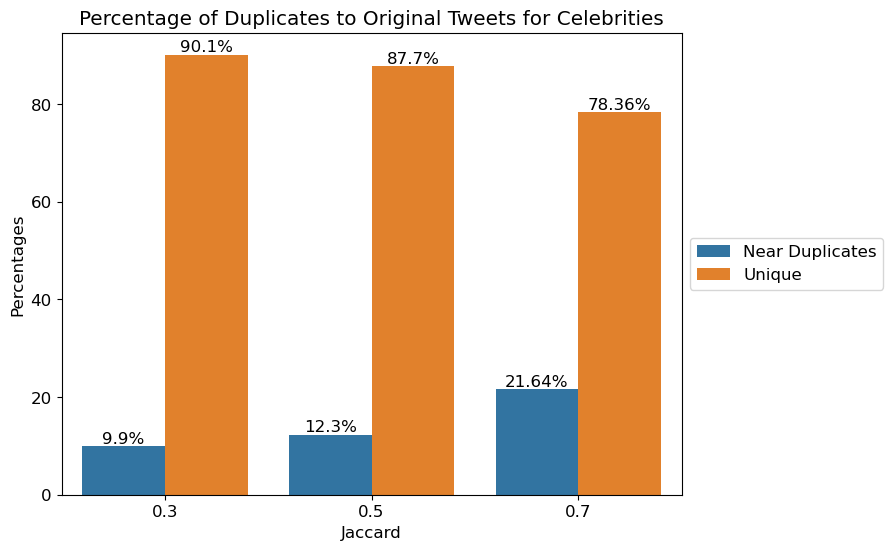

In [148]:
fig_celeb = plot(celeb)
plt.title("Percentage of Duplicates to Original Tweets for Celebrities")
plt.show()

In [67]:
df_hashed.unpersist()
df_hashed_celeb.unpersist()

id,text,list_of_words,features,hashes
26,{gators headed ba...,"[gators, headed, ...","(16499,[0,1,19,39...","[[4.7945584E7], [..."
29,{went pickup peyt...,"[went, pickup, pe...","(16499,[0,10,11,4...","[[1.2624605E7], [..."
65,{adventures high ...,"[adventures, high...","(16499,[0,3,7,26,...","[[4.7945584E7], [..."
19,{17 year old high...,"[17, year, old, h...","(16499,[0,3,5,10,...","[[4.7945584E7], [..."
54,{worse headline s...,"[worse, headline,...","(16499,[1,24,33,1...","[[1.45345284E8], ..."
0,{alobaid97 colleg...,"[alobaid97, colle...","(16499,[1,2,32,90...","[[3.32539396E8], ..."
112,{watched till sho...,"[watched, till, s...","(16499,[0,16,32,3...","[[6570254.0], [2...."
113,{waterproof newel...,"[waterproof, newe...","(16499,[0,12,16,1...","[[4.7945584E7], [..."
22,{elementary schoo...,"[elementary, scho...","(16499,[0,6,74,16...","[[3.8361494E7], [..."
130,{uhcougarfb unive...,"[uhcougarfb, univ...","(16499,[1,2,9,26,...","[[1.5655712E7], [..."


## 4) NGO

In [70]:
ngo_perc = 0.16

In [71]:
df_ngo = df.filter(f.col('Category') == 'Nonprofit_organization').sample(ngo_perc, seed=5555)
df_ngo.count()

294

### Raw

In [72]:
ngo_raw = df_ngo.select(['tweet_text']).withColumnRenamed('tweet_text', 'text')

In [73]:
ngo_extracted = ngo_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

tokens_ngo = (ngo_extracted
        .map(lambda document: document.strip().lower()) # Remove leading and trailing characters, then convert to lower case
        .map(lambda document: re.split(" ", document)) # Split each sentence on white spaces so each word is a token
        .map(lambda word: [x for x in word if x.isalnum()]) # All characters must be alphanumeric
        .zipWithIndex())

In [74]:
row = Row('text')
df_text=ngo_extracted.map(row).zipWithIndex().toDF(['text','id'])

In [75]:
df_ngo_tokens = spark.createDataFrame(tokens_ngo, ["list_of_words",'id'])

### CountVectorizer

In [76]:
vectorize_ngo = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_ngo = vectorize_ngo.fit(df_ngo_tokens).transform(df_ngo_tokens)

In [77]:
df_vectorize_ngo.limit(5).toPandas()

,list_of_words,id,features
0,"[case, missed, giving, day, national, football, foundation, amp, college, hall, fame, nff, named, joel, ramnath, jordan, amp, roma, n, grissett, 2022, nff, hampshire, honor, society, maintaining, cumulative, 3, 2, gpa, better, throughout, college, football, careers]",0,"(0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[change, child, life, today, radically, change, life, child, need, 29, 50, month, put, child, school, provide, best, educational, resources, available, donate, orphans]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...)"
2,"[nadineaishaj, speaks, value, school, library, special, creative, space, sign, posting, making, children, aware, variety, organisations, relevant, cbiconf22, allthewayhome]",2,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[interesting, event, childcare, helenhayes, thinks, need, nurseries, able, access, specialists, support, children, well, agree, teachers, deaf, needed, theyre, vital, support, pre, school, deaf, children, sendinthespecialists, lab22]",3,"(1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[ever, seen, electric, school, bus, repowered, electric, school, bus, todays, day, dc, eesionline, amp, esbinitiative, brought, electricschoolbus, capitol, hill, join, us, 4, 30, 5, 15pm, maryland, ave, sw, next, capitol, reflecting, pool, cleanride4kids, energytwitter]",4,"(2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [78]:
df_vectorize_ngo.filter(f.size(f.col('list_of_words')) < 1).count()

0

In [79]:
df_vectorize_ngo = df_vectorize_ngo.filter((f.size(f.col('list_of_words')) >= 1))

### Minhash

In [80]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model_ngo = mh.fit(df_vectorize_ngo)
df_hashed = mh.fit(df_vectorize_ngo).transform(df_vectorize_ngo).cache()

In [81]:
df_hashed_ngo = df_text.join(df_hashed, on='id', how = 'left').cache()
df_hashed_ngo.limit(10)

id,text,list_of_words,features,hashes
19,{high school seni...,"[high, school, se...","(3157,[0,1,6,8,14...","[[4.7945584E7], [..."
54,{september 10th c...,"[september, 10th,...","(3157,[0,3,9,41,2...","[[2.7764414E7], [..."
296,{full time fr agn...,"[full, time, fr, ...","(3157,[0,11,13,15...","[[4045642.0], [2...."
22,{servepalestine t...,"[servepalestine, ...","(3157,[0,2,21,69,...","[[4.7945584E7], [..."
198,{call donations y...,"[call, donations,...","(3157,[1,5,18,65,...","[[7.9736824E7], [..."
27,{pleased join aus...,"[pleased, join, a...","(3157,[0,5,56,83,...","[[3.4831755E7], [..."
63,{u education syst...,"[u, education, sy...","(3157,[0,5,48,58,...","[[2.6252792E7], [..."
158,{children rohingy...,"[children, rohing...","(3157,[0,2,5,6,49...","[[3040515.0], [8...."
51,{week pupils acro...,"[week, pupils, ac...","(3157,[0,8,61,68,...","[[4.7945584E7], [..."
56,{help cityyearkc ...,"[help, cityyearkc...","(3157,[0,6,17,18,...","[[4.7945584E7], [..."


In [82]:
records_ngo = df_hashed_ngo.count()
records_ngo

313

### Plot

In [83]:
ngo = get_dups(model_ngo, df_hashed_ngo, records_ngo, [0.3, 0.5, 0.7])

In [84]:
ngo 

,Jaccard,Type,Percentages
0,0.3,Near Duplicates,1.28
1,0.5,Near Duplicates,6.39
2,0.7,Near Duplicates,28.43
3,0.3,Unique,98.72
4,0.5,Unique,93.61
5,0.7,Unique,71.57


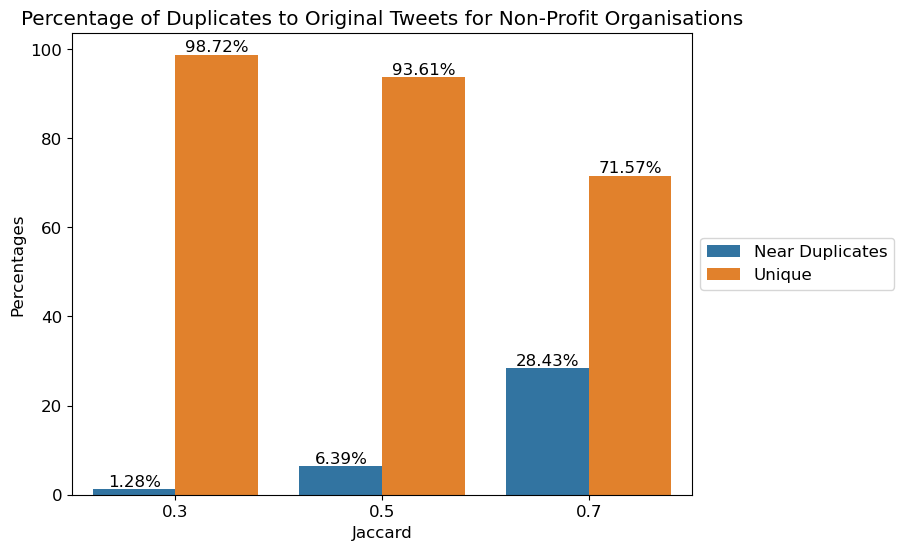

In [149]:
fig_ngo = plot(ngo)
plt.title("Percentage of Duplicates to Original Tweets for Non-Profit Organisations")
plt.show()

In [86]:
df_hashed.unpersist()
df_hashed_ngo.unpersist()

id,text,list_of_words,features,hashes
0,{case missed givi...,"[case, missed, gi...","(3157,[1,3,19,35,...","[[5.450643E7], [2..."
7,{a7 4 registered ...,"[a7, 4, registere...","(3157,[1,6,45,47,...","[[1.44324431E8], ..."
6,{great work partn...,"[great, work, par...","(3157,[0,2,31,38,...","[[4.7945584E7], [..."
9,{reward without h...,"[reward, without,...","(3157,[0,11,13,25...","[[4.7945584E7], [..."
5,{blown away atten...,"[blown, away, att...","(3157,[4,7,134,17...","[[3.1294153E7], [..."
1,{change child lif...,"[change, child, l...","(3157,[0,21,33,57...","[[4.7945584E7], [..."
3,{interesting even...,"[interesting, eve...","(3157,[0,2,36,44,...","[[3.1294153E7], [..."
8,{dkunas martherep...,"[dkunas, marthere...","(3157,[0,5,14,17,...","[[4.7945584E7], [..."
2,{nadineaishaj spe...,"[nadineaishaj, sp...","(3157,[0,2,113,12...","[[1.1112983E7], [..."
4,{ever seen electr...,"[ever, seen, elec...","(3157,[0,3,23,46,...","[[4552137.0], [7...."


## 5) News

In [25]:
news_perc = 0.16

In [26]:
df_news = df.filter(f.col('Category') == 'News').sample(news_perc, seed=1227)
df_news.count()

14234

### Raw

In [27]:
news_raw = df_news.select(['tweet_text']).withColumnRenamed('tweet_text', 'text')

In [28]:
news_extracted = news_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

tokens_news = (news_extracted
        .map(lambda document: document.strip().lower()) # Remove leading and trailing characters, then convert to lower case
        .map(lambda document: re.split(" ", document)) # Split each sentence on white spaces so each word is a token
        .map(lambda word: [x for x in word if x.isalnum()]) # All characters must be alphanumeric
        .zipWithIndex())

In [29]:
row = Row('text')
df_text=news_extracted.map(row).zipWithIndex().toDF(['text','id'])

In [30]:
df_news_tokens = spark.createDataFrame(tokens_news, ["list_of_words",'id'])

### CountVectorizer

In [31]:
vectorize_news = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_news = vectorize_news.fit(df_news_tokens).transform(df_news_tokens)

In [94]:
df_vectorize_news.limit(5).toPandas()

,list_of_words,id,features
0,"[gt, speakerralston, framed, measure, compromise, lets, state, high, school, association, enact, transgender, ban, hopefully, right, thing, go, forward, added, urge, school, officials, target, transgender, athletes, gapol]",0,"(2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[calling, new, school, long, overdue, bristol, virginia, school, board, approved, financing, lease, agreements, monday, construct, new, school, city, first, time, 50, years]",1,"(3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[fargo, school, board, votes, discharge, south, high, school, teacher, accused, immoral, conduct]",2,"(2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[daily, memphian, seeks, college, journalism, students, recent, graduates, 10, week, summer, internship, cohort, internship, period, may, 30, august, 5, deadline, applications, april, 15, learn, apply]",3,"(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[public, school, officials, new, mexico, investigating, student, brought, edible, thc, infused, candies, shared, 14, students]",4,"(1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [32]:
df_vectorize_news.filter(f.size(f.col('list_of_words')) < 1).count()

0

In [33]:
df_vectorize_news = df_vectorize_news.filter(f.size(f.col('list_of_words')) >= 1)

### Minhash

In [34]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model_news = mh.fit(df_vectorize_news)
df_hashed = mh.fit(df_vectorize_news).transform(df_vectorize_news).cache()

In [35]:
df_hashed_news = df_text.join(df_hashed, on='id', how = 'left').cache()
df_hashed_news.limit(10)

id,text,list_of_words,features,hashes
65,{school leaders t...,"[school, leaders,...","(32983,[0,3,7,9,1...","[[4.7945584E7], [..."
191,{rishi sunak affo...,"[rishi, sunak, af...","(32983,[0,2,44,46...","[[4.7945584E7], [..."
418,{said free speech...,"[said, free, spee...","(32983,[2,3,7,18,...","[[5.75251383E8], ..."
541,{viral video krug...,"[viral, video, kr...","(32983,[0,5,6,50,...","[[4.7945584E7], [..."
558,{briggs indiana c...,"[briggs, indiana,...","(32983,[2,58,781,...","[[1.2969898E8], [..."
1010,{trussville city ...,"[trussville, city...","(32983,[0,12,36,4...","[[4.7945584E7], [..."
1224,{actually little ...,"[actually, little...","(32983,[2,23,30,1...","[[4.45569674E8], ..."
1258,{carnegie mellon ...,"[carnegie, mellon...","(32983,[1,13,110,...","[[1536756.0], [2...."
1277,{also reports dro...,"[also, reports, d...","(32983,[0,8,62,69...","[[4.7945584E7], [..."
1360,{university colle...,"[university, coll...","(32983,[1,2,31,52...","[[2.0720662E7], [..."


In [36]:
records_news = df_hashed_news.count()
records_news

14379

### Plot

In [37]:
news = get_dups(model_news, df_hashed_news, records_news, [0.3, 0.5, 0.7])

In [38]:
news 

,Jaccard,Type,Percentages
0,0.3,Near Duplicates,9.53
1,0.5,Near Duplicates,11.20
2,0.7,Near Duplicates,21.52
3,0.3,Unique,90.47
4,0.5,Unique,88.80
5,0.7,Unique,78.48


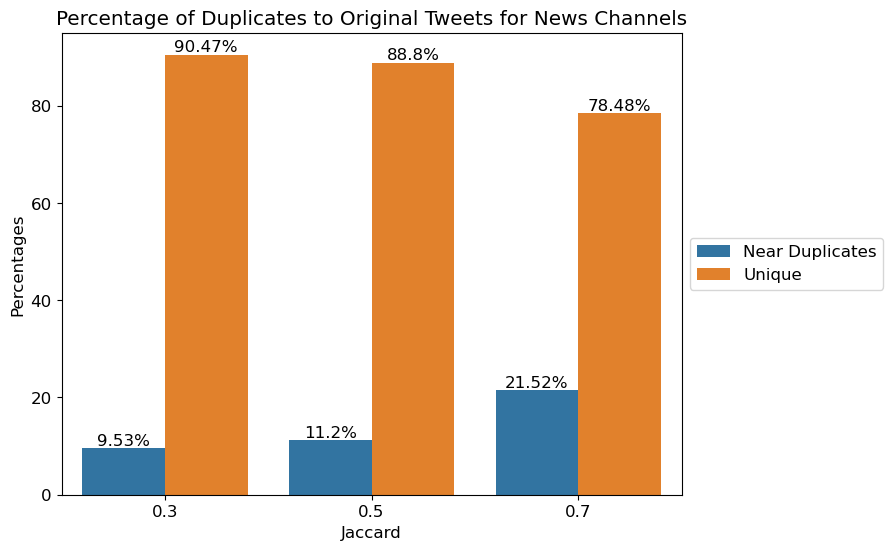

In [39]:
fig_news = plot(news)
plt.title("Percentage of Duplicates to Original Tweets for News Channels")
plt.show()

In [103]:
df_hashed.unpersist()
df_hashed_news.unpersist()

id,text,list_of_words,features,hashes
26,{timspiritmolobi ...,"[timspiritmolobi,...","(32983,[1,3,66,12...","[[2.90174665E8], ..."
29,{guest column sue...,"[guest, column, s...","(32983,[0,8,14,43...","[[4.7945584E7], [..."
474,{gmatembu2 north ...,"[gmatembu2, north...","(32983,[0,28,53,6...","[[4.7945584E7], [..."
65,{school leaders t...,"[school, leaders,...","(32983,[0,3,7,9,1...","[[4.7945584E7], [..."
191,{rishi sunak affo...,"[rishi, sunak, af...","(32983,[0,2,44,46...","[[5082221.0], [8...."
418,{said free speech...,"[said, free, spee...","(32983,[2,3,7,18,...","[[2.30106198E8], ..."
222,{weve got covered...,"[weve, got, cover...","(32983,[1,164,202...","[[1.89743858E8], ..."
270,{university orego...,"[university, oreg...","(32983,[1,16,497,...","[[4.4415845E7], [..."
293,{meet justin colo...,"[meet, justin, co...","(32983,[2,3,307,3...","[[7.6207085E7], [..."
243,{new peninsula hi...,"[new, peninsula, ...","(32983,[0,3,4,5,1...","[[4.7945584E7], [..."


## 6) Influencer

In [106]:
influencer_perc = 0.85

In [107]:
df_inluencer = df.filter(f.col('Category') == 'Influencer').sample(influencer_perc, seed=1227)
df_inluencer.count()

5104

### Raw

In [108]:
influencer_raw = df_inluencer.select(['tweet_text']).withColumnRenamed('tweet_text', 'text')

In [109]:
influencer_extracted = influencer_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

tokens_influencer = (influencer_extracted
        .map(lambda document: document.strip().lower()) # Remove leading and trailing characters, then convert to lower case
        .map(lambda document: re.split(" ", document)) # Split each sentence on white spaces so each word is a token
        .map(lambda word: [x for x in word if x.isalnum()]) # All characters must be alphanumeric
        .zipWithIndex())

In [110]:
row = Row('text')
df_text=influencer_extracted.map(row).zipWithIndex().toDF(['text','id'])

In [111]:
df_influencer_tokens = spark.createDataFrame(tokens_influencer, ["list_of_words",'id'])

### CountVectorizer

In [112]:
vectorize_influencer = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_influencer = vectorize_influencer.fit(df_influencer_tokens).transform(df_influencer_tokens)

In [113]:
df_vectorize_influencer.limit(5).toPandas()

,list_of_words,id,features
0,"[kosdff, true, financial, burden, even, 90, whole, generation, young, people, cannot, afford, lot, od, things, paying, much, student, loans, also, believe, federally, back, loans, inflate, college, tuitions]",0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...)"
1,"[mother, secondary, school, teacher, dad, trader, insane, stuff, plain, old, boring, ass, daily, work, involve, classified, insane, stuff]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[piece, marketplace, im, looking, talk, college, student, hasnt, filed, taxes, yet, maybe, worked, year, received, financial, aid, isnt, planning, maybe, someone, know, shughes, marketplace, org, 267, 388, 1450]",2,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[said, say, school, tbaslighmiddle, one, best, middle, school, campuses, country, supporters, kids, staff, make, tampa, artist, gives, back, students, middle, school, mural]",3,"(3.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[whole, thread, especially, tweet, story, young, student, raped, university, football, player, man, believed, helped]",4,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...)"


In [114]:
df_vectorize_influencer.filter(f.size(f.col('list_of_words')) < 1).count()

0

In [115]:
df_vectorize_influencer = df_vectorize_influencer.filter(f.size(f.col('list_of_words')) >= 1)

### Minhash

In [116]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model_influencer = mh.fit(df_vectorize_influencer)
df_hashed = mh.fit(df_vectorize_influencer).transform(df_vectorize_influencer).cache()

In [117]:
df_hashed_influencer = df_text.join(df_hashed, on='id', how = 'left').cache()
df_hashed_influencer.limit(10)

id,text,list_of_words,features,hashes
26,{argument student...,"[argument, studen...","(19061,[0,3,5,8,8...","[[4.7945584E7], [..."
29,{always great way...,"[always, great, w...","(19061,[0,13,16,2...","[[2.1710063E7], [..."
474,{remembering time...,"[remembering, tim...","(19061,[0,11,24,2...","[[4.7945584E7], [..."
964,{moving child col...,"[moving, child, c...","(19061,[1,4,9,24,...","[[2.61390943E8], ..."
1677,{friend fail work...,"[friend, fail, wo...","(19061,[0,8,72,84...","[[4.7945584E7], [..."
1697,{breaking arizona...,"[breaking, arizon...","(19061,[0,6,43,10...","[[1.4642722E7], [..."
1806,{mrianleslie went...,"[mrianleslie, wen...","(19061,[0,2,18,19...","[[4.7945584E7], [..."
1950,{yeah im nepo bab...,"[yeah, im, nepo, ...","(19061,[0,11,32,4...","[[6570254.0], [2...."
2040,{lot science comm...,"[lot, science, co...","(19061,[0,4,19,28...","[[4.7945584E7], [..."
2214,{observer publish...,"[observer, publis...","(19061,[1,4,16,11...","[[9.4876633E7], [..."


In [118]:
records_influencer = df_hashed_influencer.count()
records_influencer

5072

### Plot

In [119]:
influencer = get_dups(model_influencer, df_hashed_influencer, records_influencer, [0.3, 0.5, 0.7])

In [120]:
influencer 

,Jaccard,Type,Percentages
0,0.3,Near Duplicates,20.43
1,0.5,Near Duplicates,21.61
2,0.7,Near Duplicates,27.33
3,0.3,Unique,79.57
4,0.5,Unique,78.39
5,0.7,Unique,72.67


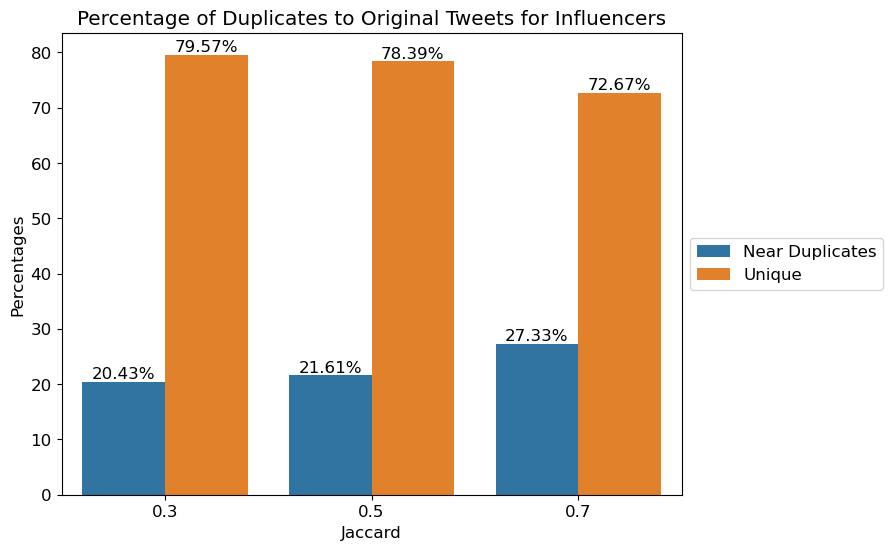

In [151]:
fig_influencer = plot(influencer)
plt.title("Percentage of Duplicates to Original Tweets for Influencers")
plt.show()

In [122]:
df_hashed.unpersist()
df_hashed_influencer.unpersist()

id,text,list_of_words,features,hashes
26,{argument student...,"[argument, studen...","(19061,[0,3,5,8,8...","[[4.7945584E7], [..."
29,{always great way...,"[always, great, w...","(19061,[0,13,16,2...","[[2.1710063E7], [..."
65,{get advice curre...,"[get, advice, cur...","(19061,[1,5,9,16,...","[[6.3085393E7], [..."
19,{kerim guess old ...,"[kerim, guess, ol...","(19061,[0,11,16,2...","[[3.331227E7], [2..."
54,{recent study rel...,"[recent, study, r...","(19061,[9,12,51,1...","[[1.8686819E7], [..."
0,{kosdff true fina...,"[kosdff, true, fi...","(19061,[1,7,22,25...","[[9.0333904E7], [..."
112,{check expert ins...,"[check, expert, i...","(19061,[2,9,80,83...","[[1.6660839E7], [..."
113,{today honour lit...,"[today, honour, l...","(19061,[0,4,16,44...","[[4.7945584E7], [..."
155,{labortwitter any...,"[labortwitter, an...","(19061,[1,5,7,41,...","[[4.390935E7], [2..."
167,{favorite posts 2...,"[favorite, posts,...","(19061,[1,3,7,48,...","[[6095211.0], [1...."


## 7) Other

In [128]:
other_perc = 0.0007

In [129]:
df_other = df.filter(f.col('Category') == 'Other').sample(other_perc, seed=1227)
df_other.count()

8846

### Raw

In [130]:
other_raw = df_other.select(['tweet_text']).withColumnRenamed('tweet_text', 'text')

In [131]:
other_extracted = other_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

tokens_other = (other_extracted
        .map(lambda document: document.strip().lower()) # Remove leading and trailing characters, then convert to lower case
        .map(lambda document: re.split(" ", document)) # Split each sentence on white spaces so each word is a token
        .map(lambda word: [x for x in word if x.isalnum()]) # All characters must be alphanumeric
        .zipWithIndex())

In [132]:
row = Row('text')
df_text=other_extracted.map(row).zipWithIndex().toDF(['text','id'])

In [133]:
df_other_tokens = spark.createDataFrame(tokens_other, ["list_of_words",'id'])

### CountVectorizer

In [134]:
vectorize_other = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_other = vectorize_other.fit(df_other_tokens).transform(df_other_tokens)

In [135]:
df_vectorize_other.limit(5).toPandas()

,list_of_words,id,features
0,"[super, proud, outcome, first, prospectwiresb, nextgen, pro, combine, last, weekend, pw, nextgen, games, held, college, station, tons, data, captured, analyzer, reports, shared, college, coaches, help, jump, start, summer, recruiting]",0,"(0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[actuarian, formerly, gsis, amp, professorial, lecturer, graduate, school, math, comments, pulse, asia, skewed, sampling, pulseasia, nakakahalata, na, ang, mga, actuarians, may, recommendations, po, rito, fix, skewed, sampling]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[wow, daughter, came, home, school, livid, today, little, boy, forgot, lunch, class, teachers, watching, lunchroom, told, rule, forget, lunch, class, buy, school, lunch, dont, eat, little, boy, started, crying, 1, 3]",2,"(2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[academic, awards, keep, rolling, congrats, following, seniors, recognized, thsca, maggie, prewitt, 1st, team, academic, state, texas, high, school, coaches, association, lili, gregory, 2nd, team, academic, state, texas, high, school, coaches, association]",3,"(2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[criticized, musk, worker, violations, tesla, blocked, college, student, started, twitter, account, track, musk, private, plane, musk, tried, buy, blocking, sound, like, free, speech, absolutist]",4,"(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [136]:
df_vectorize_other.filter(f.size(f.col('list_of_words')) < 1).count()

0

In [137]:
df_vectorize_other = df_vectorize_other.filter(f.size(f.col('list_of_words')) >= 1)

### Minhash

In [138]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model_other = mh.fit(df_vectorize_other)
df_hashed = mh.fit(df_vectorize_other).transform(df_vectorize_other).cache()

In [139]:
df_hashed_other = df_text.join(df_hashed, on='id', how = 'left').cache()
df_hashed_other.limit(10)

id,text,list_of_words,features,hashes
26,{college student ...,"[college, student...","(27812,[2,3,2538,...","[[5.75251383E8], ..."
29,{job alert im loo...,"[job, alert, im, ...","(27812,[0,2,34,47...","[[4.7945584E7], [..."
474,{muhd kamil taufi...,"[muhd, kamil, tau...","(27812,[0,9,219,2...","[[5105810.0], [7...."
964,{days russia inva...,"[days, russia, in...","(27812,[0,4,17,28...","[[1.9185451E7], [..."
1677,{call papers spri...,"[call, papers, sp...","(27812,[1,2,15,59...","[[4.492234E7], [6..."
1697,{maymay2umbrella ...,"[maymay2umbrella,...","(27812,[0,8,48,22...","[[2.9813983E7], [..."
1806,{three years late...,"[three, years, la...","(27812,[1,3,26,12...","[[1.66040812E8], ..."
1950,{mmpadellan teach...,"[mmpadellan, teac...","(27812,[0,7,28,38...","[[4.7945584E7], [..."
2040,{tw su cide guess...,"[tw, su, cide, gu...","(27812,[1,3,8,74,...","[[2534020.0], [2...."
2214,{cisd named best ...,"[cisd, named, bes...","(27812,[0,5,93,10...","[[4.7945584E7], [..."


In [140]:
records_other = df_hashed_other.count()
records_other

8948

### Plot

In [141]:
other = get_dups(model_other, df_hashed_other, records_other, [0.3, 0.5, 0.7])

In [142]:
other

,Jaccard,Type,Percentages
0,0.3,Near Duplicates,31.97
1,0.5,Near Duplicates,35.48
2,0.7,Near Duplicates,44.45
3,0.3,Unique,68.03
4,0.5,Unique,64.52
5,0.7,Unique,55.55


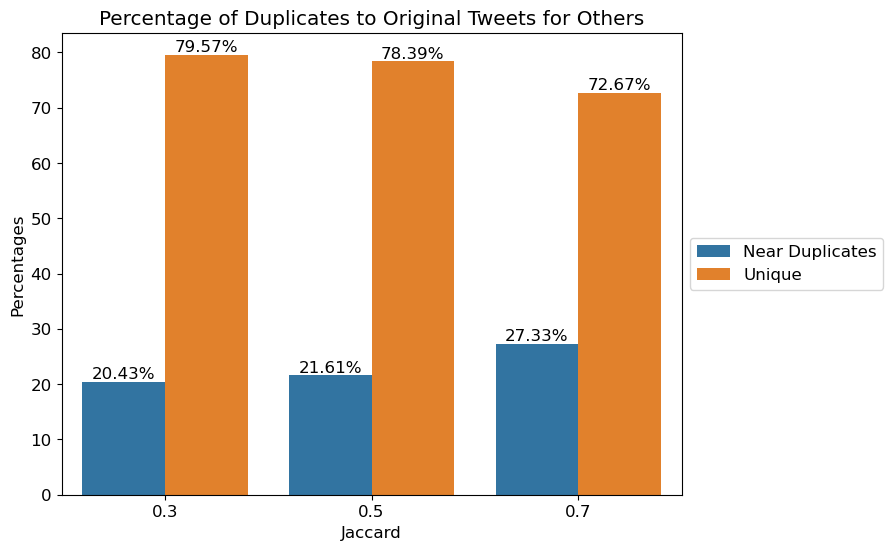

In [152]:
fig_influencer = plot(influencer)
plt.title("Percentage of Duplicates to Original Tweets for Others")
plt.show()


In [144]:
df_hashed.unpersist()
df_hashed_other.unpersist()

id,text,list_of_words,features,hashes
26,{college student ...,"[college, student...","(27812,[2,3,2538,...","[[5.75251383E8], ..."
29,{job alert im loo...,"[job, alert, im, ...","(27812,[0,2,34,47...","[[4.7945584E7], [..."
65,{young boy residi...,"[young, boy, resi...","(27812,[0,11,18,2...","[[4.7945584E7], [..."
191,{ziwe emrata omg ...,"[ziwe, emrata, om...","(27812,[0,2,20,23...","[[9408.0], [1.755..."
222,{marshablackburn ...,"[marshablackburn,...","(27812,[1,6,10,17...","[[1.04460723E8], ..."
270,{high school teac...,"[high, school, te...","(27812,[0,3,7,9,1...","[[4.7945584E7], [..."
293,{black students n...,"[black, students,...","(27812,[0,8,10,21...","[[7076749.0], [9...."
243,{school college j...,"[school, college,...","(27812,[0,2,6,106...","[[4.5927467E7], [..."
278,{child strong eno...,"[child, strong, e...","(27812,[0,16,18,7...","[[4.7945584E7], [..."
19,{boomers tuition ...,"[boomers, tuition...","(27812,[2,3,5,11,...","[[7.5194095E7], [..."
